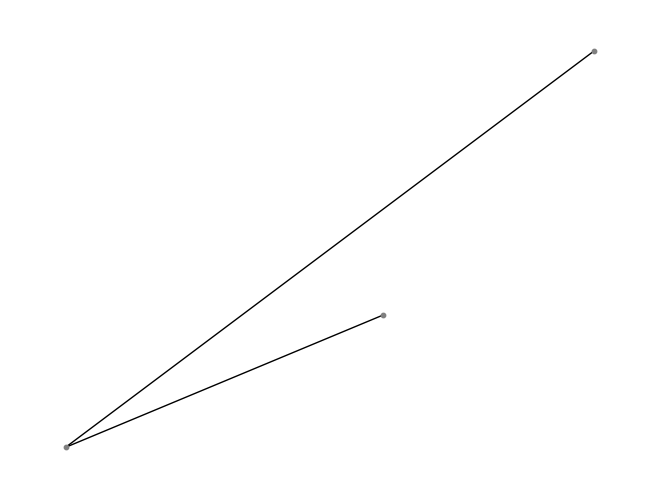

In [8]:
import simpy
import tkinter as tk
import random
import math
import networkx as nx

class Car:
    def __init__(self, canvas, x, y):
        self.canvas = canvas
        self.x = x
        self.y = y
        self.radius = 5
        self.destination = None
        self.shape = None

    def draw(self):
        x0 = self.x - self.radius
        y0 = self.y - self.radius
        x1 = self.x + self.radius
        y1 = self.y + self.radius
        self.shape = self.canvas.create_oval(x0, y0, x1, y1, fill="blue")

    def move_to_destination(self):
        if self.destination is None:
            self.destination = (random.randint(0, self.canvas.winfo_width()), 
                                random.randint(0, self.canvas.winfo_height()))

    def move(self):
        if self.destination is not None:
            dx = self.destination[0] - self.x
            dy = self.destination[1] - self.y
            distance = math.sqrt(dx**2 + dy**2)
            if distance > 1:  # Only move if the distance is greater than 1
                speed = 1  # Adjust the speed as needed
                self.x += (dx / distance) * speed
                self.y += (dy / distance) * speed
                self.canvas.coords(self.shape, self.x - self.radius, self.y - self.radius,
                                   self.x + self.radius, self.y + self.radius)
            else:
                print("Car reached its destination!")


# class RoadNetwork:
#     def __init__(self, env, width, height):
#         self.env = env
#         self.width = width
#         self.height = height
#         self.cars = []
#         self.destinations = []
#         self.graph = nx.Graph()

class RoadNetwork:
    def __init__(self, env, width, height):
        self.env = env
        # self.canvas = canvas
        self.width = width
        self.height = height
        self.cars = []
        self.destinations = []
        self.graph = nx.Graph()

    def create_graph(self):
        # Define the intersections and their positions
        intersections = {
            'A': (100, 100),
            'B': (400, 200),
            'C': (600, 400)
        }

        # Add nodes for each intersection
        for intersection, position in intersections.items():
            node_id = intersection
            self.graph.add_node(node_id, pos=position)

        # Define the connections between intersections
        connections = {
            'A': ['B', 'C'],
            'B': ['A'],
            'C': ['A']
        }

        # Add edges between connected intersections
        for intersection, neighbors in connections.items():
            for neighbor in neighbors:
                self.graph.add_edge(intersection, neighbor)

    def place_car(self, x, y):
        car = Car(self.canvas, x, y)
        self.cars.append(car)
        car.draw()

    def draw_destination(self, x, y):
        x0 = x - 3
        y0 = y - 3
        x1 = x + 3
        y1 = y + 3
        self.canvas.create_oval(x0, y0, x1, y1, fill="red")
        self.destinations.append((x, y))

env = simpy.Environment()
# root = tk.Tk()
# canvas = tk.Canvas(root, width=800, height=600)
# canvas.pack()

network = RoadNetwork(env, 800, 600)
# network.create_grid(rows=10, cols=8)

# network.create_grid(rows=10, cols=8)
network.create_graph()

# Place cars at specific positions
# network.place_car(x=100, y=100)
# network.place_car(x=300, y=200)
# network.place_car(x=600, y=400)

# Set random destinations for the cars
for car in network.cars:
    car.move_to_destination()
    network.draw_destination(car.destination[0], car.destination[1])

def simulate_movement():
    while True:
        for car in network.cars:
            car.move()
        if all(car.destination is None for car in network.cars):
            print("All cars reached their destination!")
            break
        yield env.timeout(0.1)  # Adjust the simulation time step as needed

fps = 60
duration = 10

# env = simpy.rt.RealtimeEnvironment(factor=1/fps, strict=False)
# env.process(simulate_movement())
# env.run(until=10)  # Adjust the simulation duration as needed
# env.run(until=duration * fps + 1)


# Draw the road network graph
pos = nx.get_node_attributes(network.graph, 'pos')
nx.draw(network.graph, pos=pos, node_size=10, node_color='gray')

# root.mainloop()